# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [1]:
pip install google-cloud-bigquery

Note: you may need to restart the kernel to use updated packages.


In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [2]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
print(pd.__version__)  # Hauria de mostrar la versió (ex: '2.1.3')

2.1.4


In [22]:
pip install --upgrade pandas google-cloud-bigquery

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.
pycaret 3.3.2 requires pandas<2.2.0, but you have pandas 2.2.3 which is incompatible.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import db_dtypes
print(db_dtypes.__version__)  # Hauria de mostrar la versió (ex: 1.2.0)


1.4.2


In [4]:
query = """
SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  a.intime,
  a.outtime,
  i.icd_code,
  d.icd_version,
  d.long_title,
  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,
  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,
  readmit.stay_id AS readmitted_stay
FROM
  `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN
  `ogi-uci-i61.mimiciv_hosp.patients` p
  ON a.subject_id = p.subject_id
JOIN
  `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  ON a.hadm_id = i.hadm_id
JOIN
  `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d
  ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
LEFT JOIN (
  -- Select first GCS per stay
  SELECT
    stay_id,
    gcs_verbal,
    gcs_motor,
    gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM
    `ogi-uci-i61.mimiciv_derived.gcs`
) s
  ON a.stay_id = s.stay_id AND s.rn = 1
LEFT JOIN (
  -- Select first vitals per stay
  SELECT
    stay_id,
    heart_rate,
    mbp,
    resp_rate,
    temperature,
    spo2,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM
    `ogi-uci-i61.mimiciv_derived.vitalsign`
) vitals
  ON a.stay_id = vitals.stay_id AND vitals.rn = 1
LEFT JOIN (
  -- Identify next stay as readmission
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM
    `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN
    `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id
    AND a2.intime > a1.outtime
  GROUP BY
    a1.subject_id, a1.stay_id
) readmit
  ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id
WHERE
  LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
"""
df = client.query(query).to_dataframe()

/opt/homebrew/Caskroom/miniforge/base/envs/ogi/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [7]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 3. 🧽 Preprocesamiento

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Relleno de valores nulos
# df.fillna(df.median(numeric_only=True), inplace=True) ## NO FUNCIONA pq estem intentant
# reemplaçar tipus int a float.

# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

# podem convertir totes les columnes Int64 a float64 ja que la funció median()
# retorna sempre un valor float
# com que hi ha columnes que contenen strings (object) no podem fer mediana , però 
# podem codificar-les amb la funció OneHotEncoder, que donarà valors 0 i 1 a strings
# com de gènere home 'M' o dona 'F' (ex: 'M' → 0, 'F' → 1)


subject_id                  Int64
hadm_id                     Int64
stay_id                     Int64
gender                     object
intime             datetime64[us]
outtime            datetime64[us]
icd_code                   object
icd_version                 Int64
long_title                 object
gcs_verbal                float64
gcs_motor                 float64
gcs_eyes                  float64
heart_rate                float64
mbp                       float64
resp_rate                 float64
temperature                object
spo2                      float64
readmitted_stay             Int64
dtype: object


In [6]:
from sklearn.preprocessing import OneHotEncoder

# Codifica 'gender' (ex: 'M' → 0, 'F' → 1)
encoder = OneHotEncoder()
encoded_gender = encoder.fit_transform(df[['gender']]).toarray()

# Reemplaça la columna original amb les noves columnes codificades
df_encoded = pd.concat([df.drop(columns=['gender']), pd.DataFrame(encoded_gender, columns=encoder.get_feature_names_out(['gender']))], axis=1)

In [7]:
# CODI ORIGINAL --> REVISAT OKK

# Escalado de características numéricas
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df.select_dtypes(include='number'))

# Target: readmisión
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)

## 4. 📊 Modelado Predictivo

In [9]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 35.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 43.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pillow━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  7/33 [ruff]
    Found existing installation: pillow 11.2.1━━━━━━━━━━━━━━━━  7/33 [ruff]
    Uninstalling pillow-11.2.1:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  7/33 [ruff]
      Successfully uninstalled pillow-11.2.1━━━━━━━━━━━━━━━━━━  7/33 [ruff]
  Attempting uninstall: markupsafem━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/33 [pillow]
    Found existing installation: MarkupSafe 3.0.2━━━━━━━━━━━━━ 11/33 [pillow]
    Uninstalling MarkupSafe-3.0.2:0m━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/33 [pillow]
      Successfully uninstalled MarkupSafe-3.0.2━━━━━━━━━━━━━━━ 11/33 [pillow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33/33 [gradio

In [10]:
import gradio as gr

In [16]:
# Instal·lem Pycaret per provar diferents ALGORITMES DE MACHINE LEARNING

pip install Pycaret

SyntaxError: invalid syntax (1558059053.py, line 3)

In [17]:
pip install --upgrade pycaret

Defaulting to user installation because normal site-packages is not writeable
  Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
  Using cached pandas-2.1.4-cp39-cp39-macosx_11_0_arm64.whl (11.0 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
  Using cached scipy-1.11.4-cp39-cp39-macosx_12_0_arm64.whl (29.7 MB)
  Using cached scikit_learn-1.4.2-cp39-cp39-macosx_12_0_arm64.whl (10.5 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: scikit-learn
    Found existing installati

In [11]:
import sklearn
print("scikit-learn:", sklearn.__version__)  # Hauria de ser 1.2.2
import pycaret
print("PyCaret:", pycaret.__version__)      # Hauria de ser >= 3.0.0

scikit-learn: 1.4.2
PyCaret: 3.3.2


In [12]:

# Paso 1: Importar las Bibliotecas Necesarias y Crear un Dataset Ficticio

from pycaret.classification import *
import os
from pycaret.classification import plot_model
from pycaret.classification import predict_model, pull, load_model


In [13]:
print(df['icd_code'].value_counts())

icd_code
431       1420
I618       573
I615       564
I611       499
I619       278
I610       231
I614       188
I612        91
I613        71
I69198      49
I69151      43
I616        39
I69120      24
I69154      23
I69192      18
I69122      16
I69191      11
I69119       3
I69112       2
I69193       2
I69128       2
I69121       2
I69134       2
I69131       2
I6911        2
I69153       1
I69165       1
I69152       1
I69144       1
I69118       1
Name: count, dtype: int64


In [14]:
df.head()


,subject_id,hadm_id,stay_id,gender,intime,outtime,icd_code,icd_version,long_title,gcs_verbal,gcs_motor,gcs_eyes,heart_rate,mbp,resp_rate,temperature,spo2,readmitted_stay,readmitted
0,10763729,25978404,36052003,M,2181-11-22 00:59:00,2181-12-07 17:27:23,431,9,Intracerebral hemorrhage,0.0,1.0,1.0,NaN,98.0,30.0,None,100.0,36052003,1
1,10763729,25978404,36434459,M,2181-12-09 01:21:42,2181-12-12 16:58:04,431,9,Intracerebral hemorrhage,4.0,6.0,4.0,NaN,90.0,NaN,None,NaN,<NA>,0
2,14306582,20415671,36446573,M,2158-12-01 07:36:00,2158-12-17 21:58:12,431,9,Intracerebral hemorrhage,0.0,5.0,2.0,NaN,NaN,NaN,None,NaN,<NA>,0
3,10173219,22913226,32333688,M,2153-11-24 17:45:48,2154-01-12 15:57:12,I69120,10,Aphasia following nontraumatic intracerebral h...,0.0,5.0,2.0,59.0,NaN,14.0,36.890000000,90.0,<NA>,0
4,10208612,26337634,37520781,M,2183-11-08 14:10:00,2183-11-09 13:06:17,I69122,10,Dysarthria following nontraumatic intracerebra...,1.0,4.0,1.0,69.0,NaN,15.0,None,92.0,<NA>,0


In [16]:
# Configurem entorn PyCaret

clf = setup(data=df, target='readmitted_stay', session_id=123, verbose=True)

ValueError: 3222 missing values found in the target column: readmitted_stay. To proceed, remove the respective rows from the data. 

In [46]:
# Paso 4: Comparar Modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()


Comparant models........ esperant........ pot tardar uns minuts...


RuntimeError: This function/method requires the users to run setup() first.
More info: https://pycaret.gitbook.io/docs/get-started/quickstart

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

X = features_scaled
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       806
           1       1.00      1.00      1.00       234

    accuracy                           1.00      1040
   macro avg       1.00      1.00      1.00      1040
weighted avg       1.00      1.00      1.00      1040

AUC: 1.0


## 5. 📈 Visualización de Resultados

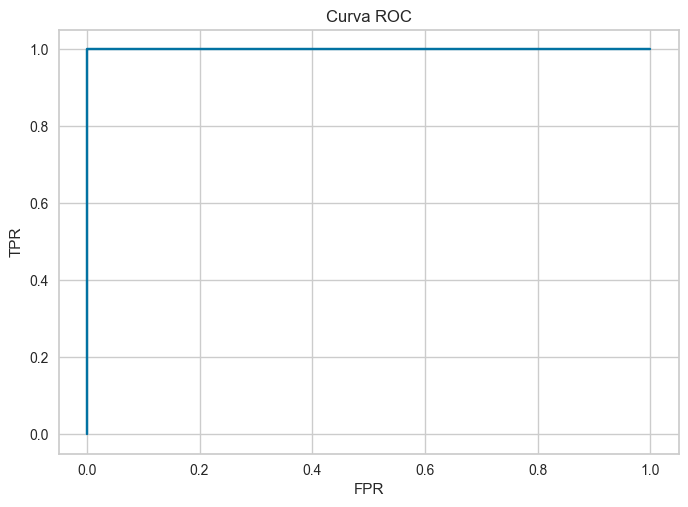

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.show()

## 6. 🚀 Despliegue (Futuro)
Se puede utilizar Hugging Face Spaces o Streamlit Cloud para desplegar un frontend que permita:
- Cargar variables clínicas
- Obtener un score de riesgo
- Visualizar el gráfico ROC o una matriz de confusión